In [389]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

torch.manual_seed(2024)
np.random.seed(2024)

In [390]:
# Define LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, num_layers, embedding_dim):
        super(LSTMAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.encoder = nn.LSTM(n_features, embedding_dim, num_layers, batch_first=True)
        self.middle = nn.Linear(embedding_dim, embedding_dim*2)
        self.decoder = nn.LSTM(embedding_dim*2, embedding_dim, num_layers, batch_first=True)
        self.final = nn.Linear(embedding_dim, n_features)

    def forward(self, x):
        x, (_, _) = self.encoder(x)
        x = self.middle(x)
        x, (_, _) = self.decoder(x)
        x = self.final(x)
        return x

In [391]:
# Generate random sequence data
def generate_sequence_data(seq_len):
    # return np.random.rand(seq_len, 1)
    x = np.linspace(0, 50, seq_len)
    y = np.sin(x) + np.random.rand(seq_len)
    return y.reshape(-1, 1)

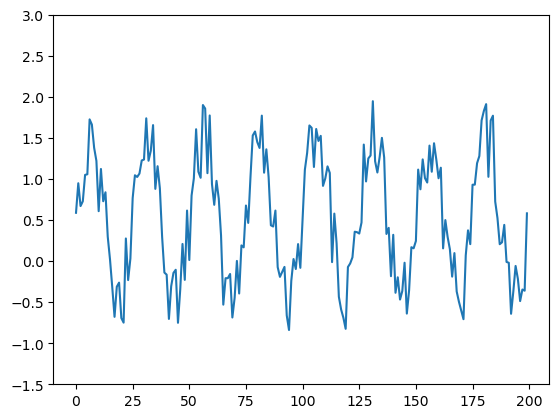

In [392]:
# Parameters
seq_len = 200
n_features = 1
embedding_dim = 64
num_layers = 1
n_epochs = 100
learning_rate = 0.001

# Create datasets
random_data = generate_sequence_data(seq_len)
train_len = int(seq_len * 0.8)
train_data, test_data = random_data[:train_len], random_data[train_len:]
test_data_abnormal = test_data.copy()
test_data_abnormal[20:30] += np.random.randn(10,1) * 3

# 오류 발생 시 런타임 유형 GPU로 변경
train_tensor = torch.tensor(train_data.reshape(1,-1,1), dtype=torch.float32).cuda()
test_tensor = torch.tensor(test_data.reshape(1,-1,1), dtype=torch.float32).cuda()
test_abnormal_tensor = torch.tensor(test_data_abnormal.reshape(1,-1,1), dtype=torch.float32).cuda()

# Plot data
plt.ylim([-1.5, 3])
plt.plot(random_data)
# plt.plot(test_data_abnormal)
# plt.plot(test_data)
plt.show()

In [393]:
# Model, loss function and optimizer
model = LSTMAutoencoder(seq_len, n_features, num_layers, embedding_dim).cuda()
criterion = nn.MSELoss(reduction='none').cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training
model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    output = model(train_tensor)
    loss = criterion(output, train_tensor)
    loss.mean().backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.mean().item()}')

Epoch 1, Loss: 0.8915206789970398
Epoch 2, Loss: 0.829630970954895
Epoch 3, Loss: 0.7735667824745178
Epoch 4, Loss: 0.7218953967094421
Epoch 5, Loss: 0.6736364364624023
Epoch 6, Loss: 0.6283982396125793
Epoch 7, Loss: 0.5865411162376404
Epoch 8, Loss: 0.5493151545524597
Epoch 9, Loss: 0.5192990899085999
Epoch 10, Loss: 0.5005998015403748
Epoch 11, Loss: 0.4971075654029846
Epoch 12, Loss: 0.5046543478965759
Epoch 13, Loss: 0.5091557502746582
Epoch 14, Loss: 0.5027428865432739
Epoch 15, Loss: 0.4872663617134094
Epoch 16, Loss: 0.46793055534362793
Epoch 17, Loss: 0.448983758687973
Epoch 18, Loss: 0.4324662387371063
Epoch 19, Loss: 0.4185318052768707
Epoch 20, Loss: 0.40628567337989807
Epoch 21, Loss: 0.39447006583213806
Epoch 22, Loss: 0.3819091022014618
Epoch 23, Loss: 0.3676507771015167
Epoch 24, Loss: 0.35113292932510376
Epoch 25, Loss: 0.3320966362953186
Epoch 26, Loss: 0.310760498046875
Epoch 27, Loss: 0.2878692150115967
Epoch 28, Loss: 0.2646458148956299
Epoch 29, Loss: 0.2424289286

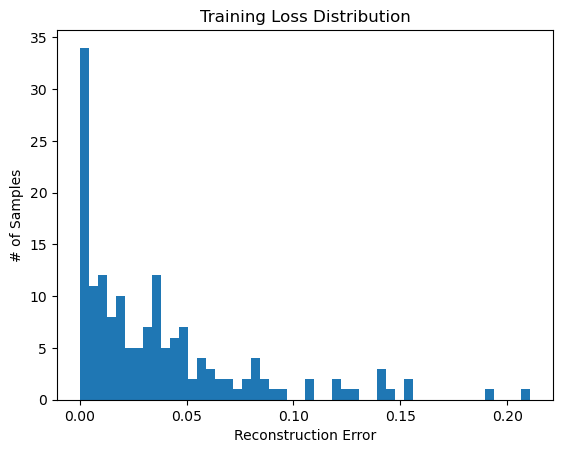

In [394]:
# Setting threshold using training loss distribution
model.eval()
with torch.no_grad():
    reconstructed = model(train_tensor)
    loss = criterion(reconstructed, train_tensor).cpu().numpy()
plt.hist(loss[0], bins=50)
plt.title('Training Loss Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('# of Samples')
plt.show()

In [395]:
# Anomaly detection
THRESHOLD = 0.3 # 위의 히스토그램을 보고 결정합니다.

model.eval()
with torch.no_grad():
    reconstructed = model(test_tensor)
    reconstructed_abnormal = model(test_abnormal_tensor)
    loss = criterion(reconstructed, test_tensor).cpu().numpy()
    loss_abnormal = criterion(reconstructed_abnormal, test_abnormal_tensor).cpu().numpy()
    anomalies = loss > THRESHOLD
    anomalies_abnormal = loss_abnormal > THRESHOLD


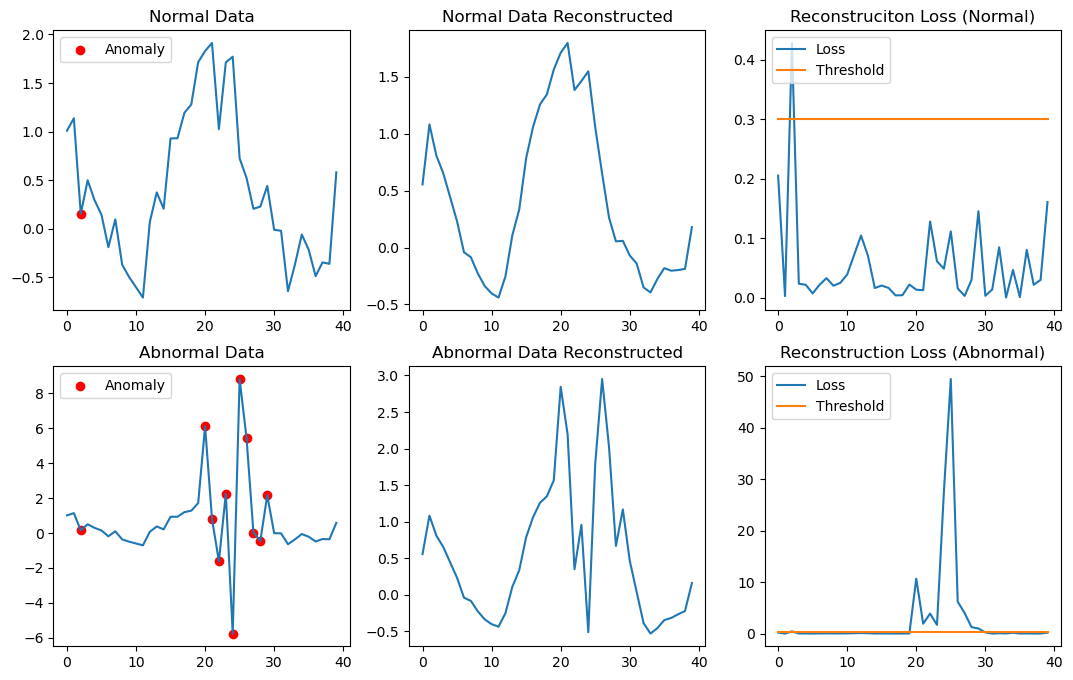

In [396]:
sample_normal = test_tensor.reshape(-1).cpu()
sample_abnormal = test_abnormal_tensor.reshape(-1).cpu()
seq_len = sample_normal.shape[0]

fig, axes = plt.subplots(2, 3, figsize=(13,8))

axes[0,0].plot(sample_normal)
anomaly_indices = np.where(anomalies[0,:,0])[0]
axes[0,0].scatter(anomaly_indices, sample_normal[anomaly_indices], c='red', label='Anomaly')
axes[0,0].set_title('Normal Data')
axes[0,0].legend()

axes[0,1].plot(reconstructed.reshape(-1).cpu())
axes[0,1].set_title('Normal Data Reconstructed')

axes[0,2].plot(loss[0], label='Loss')
axes[0,2].plot(np.arange(seq_len), np.ones(seq_len)*THRESHOLD, label='Threshold')
axes[0,2].set_title('Reconstruciton Loss (Normal)')
axes[0,2].legend(loc='upper left')

axes[1,0].plot(sample_abnormal)
anomaly_indices = np.where(anomalies_abnormal[0,:,0])[0]
axes[1,0].scatter(anomaly_indices, sample_abnormal[anomaly_indices], c='red', label='Anomaly')
axes[1,0].set_title('Abnormal Data')
axes[1,0].legend()

axes[1,1].plot(reconstructed_abnormal.reshape(-1).cpu())
axes[1,1].set_title('Abnormal Data Reconstructed')

axes[1,2].plot(loss_abnormal[0], label='Loss')
axes[1,2].set_title('Reconstruction Loss (Abnormal)')
axes[1,2].plot(np.arange(seq_len), np.ones(seq_len)*THRESHOLD, label='Threshold')
axes[1,2].legend()

plt.show()